In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, RFE
import yfinance as yf
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import itertools

In [3]:
def calculate_moving_averages(data):
    sma10 = data['Close'].shift(1).rolling(window = 10).mean()
    sma50 = data['Close'].shift(1).rolling(window = 50).mean()
    ema20 = data['Close'].shift(1).ewm(span = 20, adjust = False).mean()
    return (sma10, sma50, ema20)

def calculate_bb(data):
    rolling_mean = data['Close'].shift(1).rolling(window = 20).mean()
    rolling_std = data['Close'].shift(1).rolling(window = 20).std()
    boll_upper = rolling_mean + (2 * rolling_std)
    boll_lower = rolling_mean - (2 * rolling_std)
    return (boll_upper, boll_lower)

def calculate_macd(data):
    macd = data['Close'].shift(1).ewm(span = 12, adjust = False).mean() - data['Close'].shift(1).ewm(span = 26, adjust = False).mean()
    macd_signal = macd.ewm(span = 9, adjust = False).mean()
    return (macd, macd_signal)


In [4]:
def momentum_oscillator(data):
    stoch_k = ((data['Close'].shift(1) - data['Low'].shift(1).rolling(window = 14).min()) /
                     (data['High'].shift(1).rolling(window = 14).max() - data['Low'].shift(1).rolling(window = 14).min())) * 100

    williams_R = ((data['High'].shift(1).rolling(window = 14).max() - data['Close'].shift(1)) /
                         (data['High'].shift(1).rolling(window = 14).max() - data['Low'].shift(1).rolling(window = 14).min())) * -100
    return (stoch_k, williams_R)

def volume_indicators(data):
    # On-balance Volume (OBV)
    obv = (np.sign(data['Close'].shift(1).diff()) * data['Volume'].shift(1)).fillna(0).cumsum()

    # VWAP (Volume Weighted Average Price)
    vwap = (data['Close'].shift(1) * data['Volume'].shift(1)).cumsum() / data['Volume'].shift(1).cumsum()
    return (obv, vwap)

def directional_movement(data):
    dm_plus = np.where((data['High'].shift(1) - data['High'].shift(2)) > (data['Low'].shift(2) - data['Low'].shift(1)), 
                             np.maximum(data['High'].shift(1) - data['High'].shift(2), 0), 0)
    dm_minus = np.where((data['Low'].shift(3) - data['Low'].shift(1)) > (data['High'].shift(1) - data['High'].shift(2)), 
                              np.maximum(data['Low'].shift(2) - data['Low'].shift(1), 0), 0)
    return (dm_plus, dm_minus)

In [5]:
def feature_selection(data):
    # Select important features
    features = data.columns[7:]
    
    # Selecting Train Data
    train_data = data.loc[:'2024-03-01'].copy()
    X = train_data[features]
    y = train_data['direction']

    # 1. Mutual Information (MI)
    mi_scores = mutual_info_classif(X, y, discrete_features = False)
    mi_selected_features = pd.Series(mi_scores, index = features).nlargest(10).index.tolist()

    # 2. Recursive Feature Elimination (RFE) with RandomForest
    rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
    rfe = RFE(rf, n_features_to_select = 10)
    rfe.fit(X, y)
    rfe_selected_features = X.columns[rfe.support_].tolist()

    # Select Top Features (Union of All Methods)
    final_selected_features = list(set(mi_selected_features) | set(rfe_selected_features))
    return final_selected_features
    

In [209]:
def strategy(stock, train_data, test_data):    
    start_date = '2021-03-01'
    end_date = '2024-01-21'
    df1 = yf.download(stock, start=start_date, end=end_date)
    df1 = df1.droplevel(1, axis=1)
    df2 = train_data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    df3 = test_data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    
    # Combining all data
    df = pd.concat((df1, df2, df3))
    
    # Calculate Log Returns
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Market Direction
    df['direction'] = (df['Returns'] > 0).astype(int)
    df['direction'] = np.where(df['direction']==0, -1, df['direction'])

    # Drop NaN values
    df.dropna(inplace = True)

    # Simple & Exponential Moving Averages
    df['SMA_10'], df['SMA_50'], df['EMA_20'] = calculate_moving_averages(df)

    # Bollinger Bands
    df['boll_upper'], df['boll_lower'] = calculate_bb(df)

    # MACD & Signal Line
    df['MACD'], df['MACD_signal'] = calculate_macd(df)

    # Momentum Oscillator
    df['stoch_k'], df['williams_R'] = momentum_oscillator(df)
    
    # Volume-based Indicators
    df['OBV'], df['VWAP'] = volume_indicators(df)
    
    # Lagged Features
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Returns'].shift(lag)
        
    # Time-based Features
    df['day_of_week'] = df.index.dayofweek  # Monday = 0, Sunday = 6
    df['month'] = df.index.month  # 1-12

    # Drop NaN values
    df.dropna(inplace = True)

    # Select Top Features
    final_selected_features = feature_selection(df)
    
    # Standardize Features
    scaler = StandardScaler()
    df[final_selected_features] = scaler.fit_transform(df[final_selected_features])

    # Train-Test Split
    train_data = df.loc[:'2024-02-29'].copy()
    test_data = df.loc['2024-03-01':].copy()

    X_train, y_train = train_data[final_selected_features], train_data['direction']
    X_test, y_test = test_data[final_selected_features], test_data['direction']

    # Train Models
    if stock == "CAT":
        model = LogisticRegression(solver='lbfgs', C=0.7, random_state=12345)
        model.fit(X_train, y_train)
        
    if stock == "NKE":
        model = xgb.XGBRegressor(n_estimators=100, max_depth=6, random_state=12345)
        model.fit(X_train, y_train)
    

    # Predict & Compute Strategy Returns
    predictions = model.predict(X_test)
    test_data['pos'] = np.where(predictions < 0, -0.5, 1)
    test_data['strategy_returns'] = test_data['pos'] * test_data['Returns']
    test_data['Cumulative_Return_Strategy'] = test_data['strategy_returns'].cumsum().apply(np.exp)
    test_data.to_csv('Predictions of ga ' + stock + '.csv')

    # Compute Cumulative Return
    cumulative_return = np.exp(test_data['strategy_returns'].sum())
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 16))

    # Plot 'Close' and 'pos' with a secondary y-axis on the first subplot
    test_data[['Close', 'pos']].plot(ax=axes[0], secondary_y='pos')
    axes[0].set_xlabel('Date')  # Set x-axis label for the first subplot
    axes[0].set_ylabel('Close Price')  # Set y-axis label for the first subplot
    axes[0].right_ax.set_ylabel('Position')
    axes[0].set_title("Close Price and Position for " + stock)

    # Plot the cumulative return on the second subplot
    axes[1].plot(np.exp(test_data['strategy_returns'].cumsum()), label='Strategy Cumulative Return')
    axes[1].plot(np.exp(test_data['Returns'].cumsum()), label='Buy & Hold Cumulative Return', linestyle='--')
    axes[1].set_xlabel('Date')  # Set x-axis label for the second subplot
    axes[1].set_ylabel('Cumulative Return')  # Set y-axis label for the second subplot
    axes[1].set_title("Cumulative Returns for " + stock)
    axes[1].legend()

    print(f"Cumulative Return: {cumulative_return:.4f}") 

[*********************100%***********************]  1 of 1 completed


Cumulative Return: 1.3964


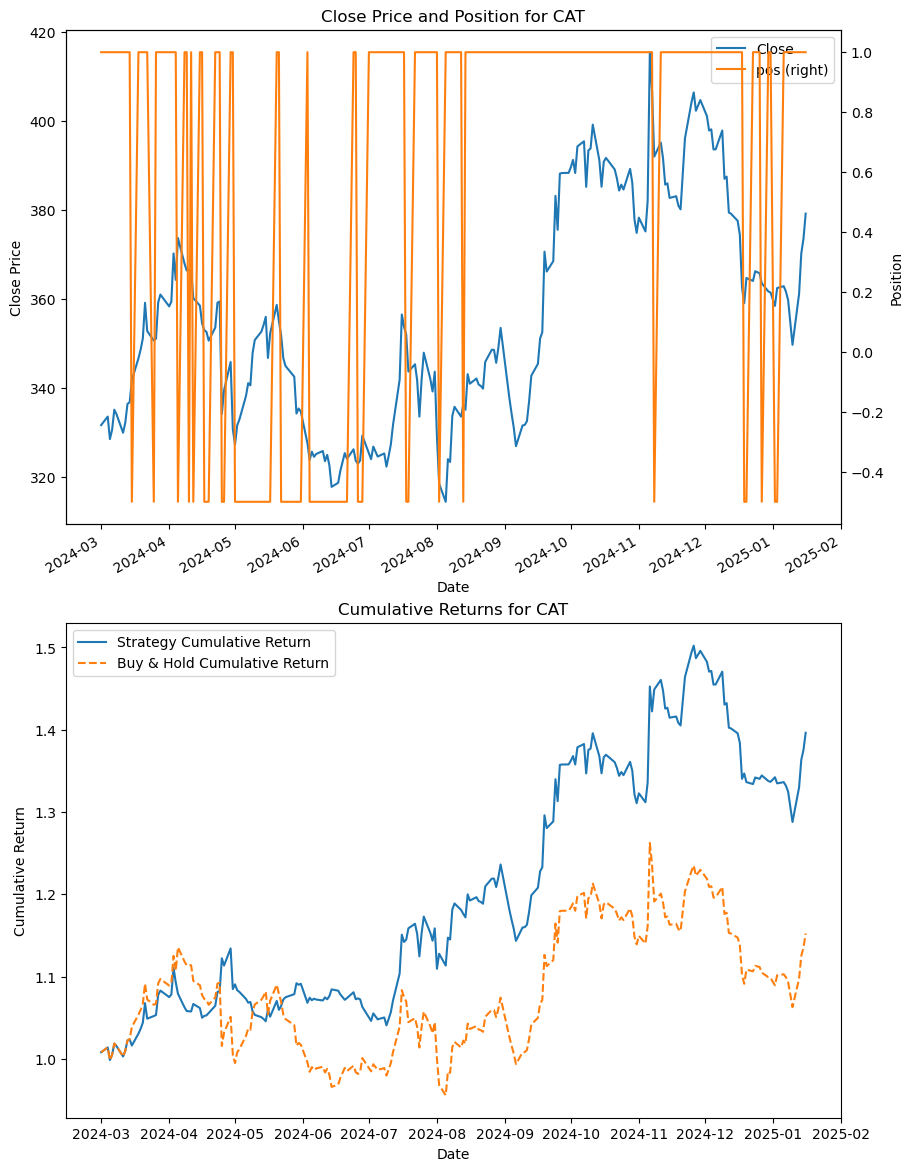

In [159]:
stock = 'CAT'
src = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)
strategy(stock, src[:'2024-02-29'], src['2024-03-01':])

[*********************100%***********************]  1 of 1 completed


Cumulative Return: 1.2285


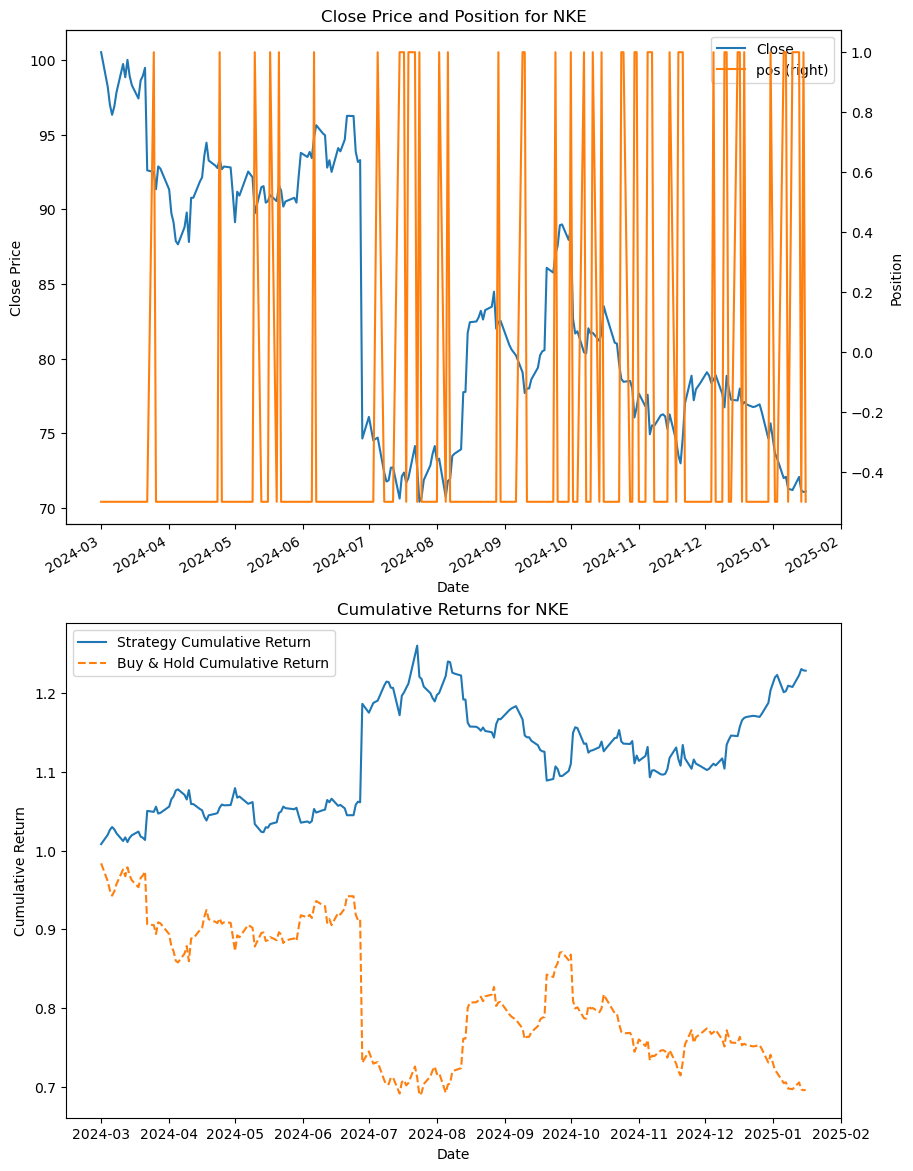

In [210]:
stock = 'NKE'
src = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)
strategy(stock, src[:'2024-02-29'], src['2024-03-01':])

[*********************100%***********************]  1 of 1 completed


Cumulative Return: 1.8066


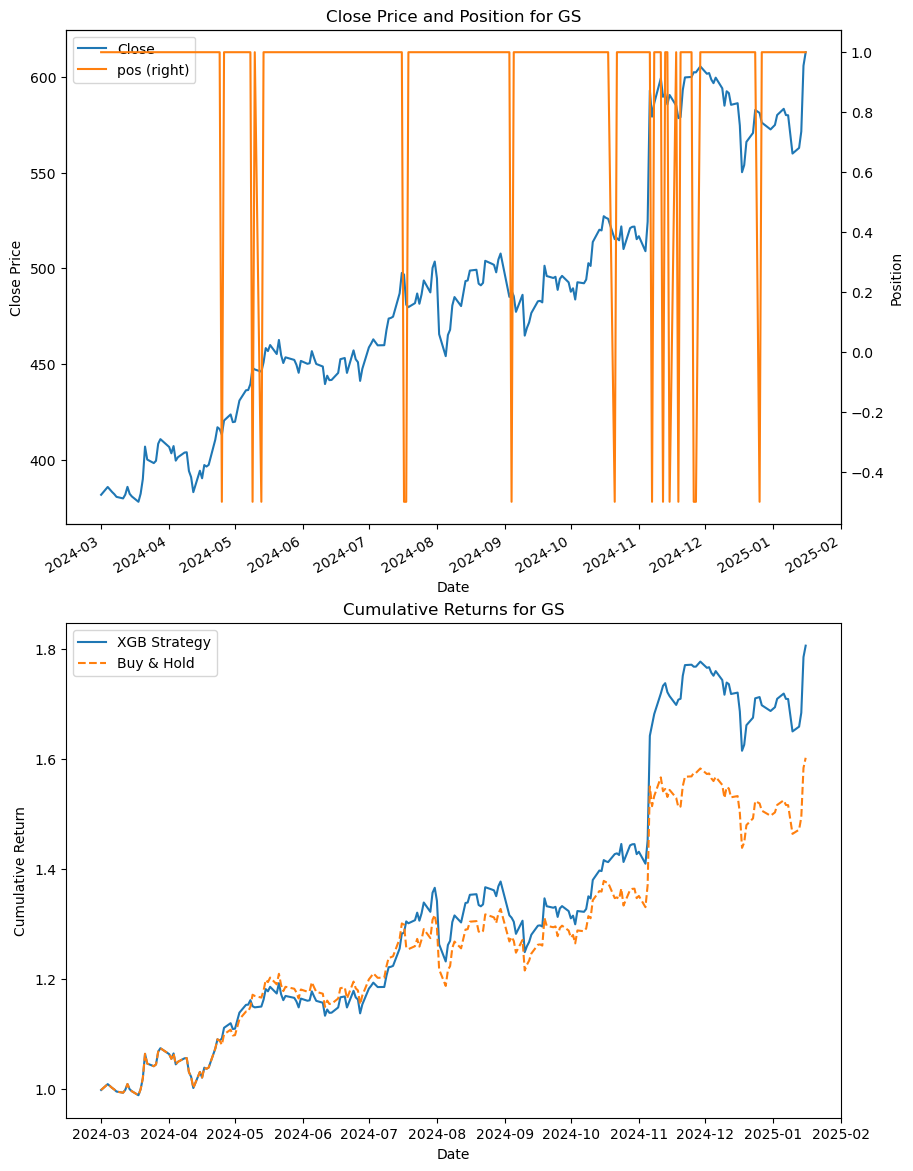

In [147]:
stock = 'GS'
src = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)
lr_strategy(stock, src[:'2024-02-29'], src['2024-03-01':])

In [15]:
def select_feature(X_train, y_train):
    # 1. Mutual Information (MI)
    mi_scores = mutual_info_classif(X_train, y_train, discrete_features=False,random_state=42)
    mi_selected = pd.Series(mi_scores, index=X_train.columns).nlargest(3).index.tolist()
    
    # 2. Recursive Feature Elimination (RFE) with RandomForest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(rf, n_features_to_select=3)
    rfe.fit(X_train, y_train)
    rfe_selected = X_train.columns[rfe.support_].tolist()
    
    # Select Top Features (Union of All Methods)
    selected_features = list(set(mi_selected + rfe_selected))
    return selected_features

In [219]:
def strategy_monthly(stock, data_train = src, data_test = src):
    # Training data
    start_date = '2021-01-01'
    end_date = '2024-01-21'
    df1 = yf.download(stock, start=start_date, end=end_date)
    df1 = df1.droplevel(1, axis=1)
    df2 = data_train[['Close', 'High', 'Open', 'Low', 'Volume']].copy()
    
    # Testing data
    df3 = data_test[['Close', 'High', 'Open', 'Low', 'Volume']].copy()
    
    # Combine and preprocess both upfront for consistency
    df = pd.concat([df1, df2, df3])
    
    # Calculate Log Returns
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Market Direction
    df['direction'] = np.where(df['Returns'] > 0, 1, 0)
    
    # Moving Averages
    ma = calculate_moving_averages(df)
    df['SMA_10'] = ma[0] 
    df['EMA_20'] = ma[2]
    
    # Bollinger Bands
    df['boll_upper'], df['boll_lower'] = calculate_bb(df)
    
    # MACD & Signal Line
    df['MACD'], df['MACD_signal'] = calculate_macd(df)
    
    # Volume-based Indicators
    df['OBV'] = volume_indicators(df)[0]
    
    # Momentum Oscillator
    df['williams_R'] = momentum_oscillator(df)[1]
    
    # Directional Movement
    df['DM_plus'], df['DM_minus'] = directional_movement(df)
    
    # Lagged Features
    df['Lag_Close'] = df['Close'].shift(1)
    df['Lag_Volume'] = df['Volume'].shift(1)
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Returns'].shift(lag)
        
    # Time-based Features
    df['day_of_week'] = df.index.dayofweek  # Monday = 0, Sunday = 6
    df['month'] = df.index.month  # 1-12

    df.dropna(inplace=True)

    # Take all features
    all_features = df.columns[7:]
    
    # Preprocessing features using Standard Scaler
    scaler = StandardScaler()
    df[all_features] = scaler.fit_transform(df[all_features])

    # Re-split after processing
    df_train = df[df.index < '2024-03-01'].copy()
    df_test = df[df.index >= '2024-03-01'].copy()

    all_test_returns = []

    current_start = pd.to_datetime('2024-03-01')
    all_predictions = []
    
    while current_start <= df_test.index[-1]:
        current_end = (current_start + pd.DateOffset(months=1)).replace(day=1)
        current_test = df_test[(df_test.index >= current_start) & (df_test.index < current_end)]

        if current_test.empty:
            break

        # Training set
        X_train = df_train[all_features]
        y_train = df_train['direction']
        
        # Select Top Features
        selected_features = select_feature(X_train, y_train)
        
        # Train model based on their stocks
        model = None
        if stock == 'GOOGL':
            model = MLPClassifier(hidden_layer_sizes=(100, 70, 70), activation='logistic', max_iter=1000, random_state=12345)
            model.fit(X_train[selected_features], y_train)
            
        # Make Predictions 
        X_test = current_test[selected_features]
        preds = model.predict(X_test)
        pos = np.where(preds == 0, -0.5, 1)
        all_predictions.extend(pos)
        
        # Compute Strategy Returns
        strategy_returns = pos * current_test['Returns']
        all_test_returns.extend(strategy_returns.tolist())

        # Update training set with newly observed data
        df_train = pd.concat([df_train, current_test])
        current_start = current_end
        
    df_test['pos'] = all_predictions
    df_test['returns_strat'] = df_test['pos'] * df_test['Returns']
    df_test['Cumulative_Return_Strategy'] = df_test['returns_strat'].cumsum().apply(np.exp)
    df_test.to_csv('Predictions of ' + stock + '.csv')
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 20))

    # Plot 'Close' and 'pos' with a secondary y-axis on the first subplot
    df_test[['Close', 'pos']].plot(ax=axes[0], secondary_y='pos')
    axes[0].set_title("Close Price and Position")
    axes[0].set_xlabel('Date')  # Set x-axis label for the first subplot
    axes[0].set_ylabel('Close Price')  # Set y-axis label for the first subplot
    axes[0].right_ax.set_ylabel('Position')
    axes[0].set_title("Close Price and Position for " + stock)

    # Plot the cumulative return on the second subplot
    axes[1].plot(np.exp(df_test['returns_strat'].cumsum()), label='Strategy Cumulative Return', linestyle='-')
    axes[1].plot(np.exp(df_test['Returns'].cumsum()), label='Buy & Hold', linestyle='--')
    axes[1].set_xlabel('Date')  # Set x-axis label for the second subplot
    axes[1].set_ylabel('Cumulative Return')  # Set y-axis label for the second subplot
    axes[1].set_title("Cumulative Returns for " + stock)
    axes[1].legend()
    
    cumulative_return = np.exp(df_test['returns_strat'].sum())
    print(f"Cumulative Return (Monthly updated): {cumulative_return:.4f}")

[*********************100%***********************]  1 of 1 completed


Cumulative Return (Monthly updated): 1.3942


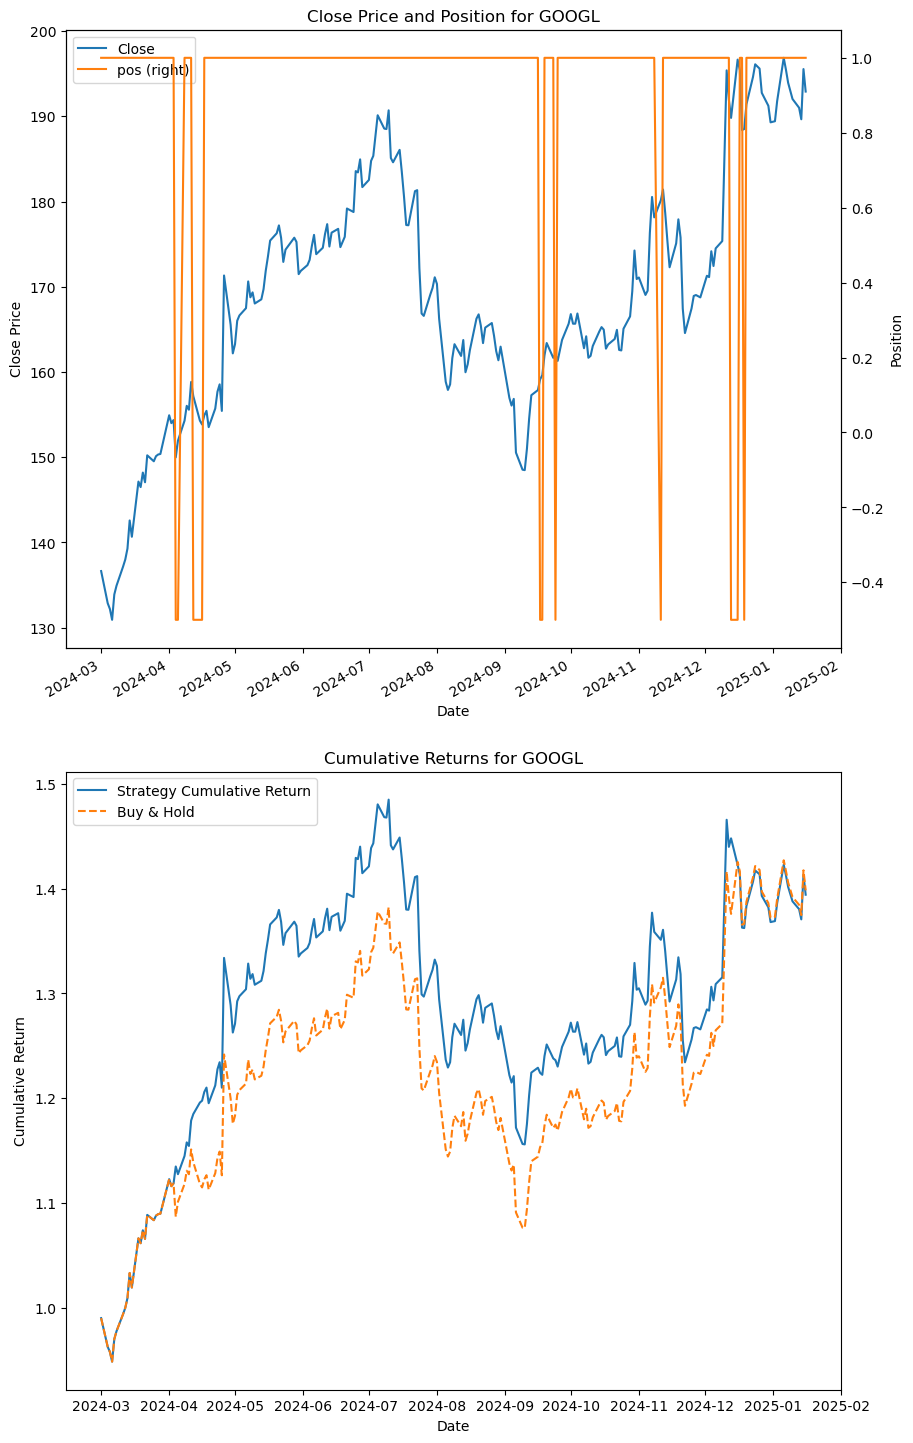

In [220]:
stock = 'GOOGL'
src = pd.read_csv(stock + '.csv', parse_dates = True, index_col = 0)
strategy_monthly(stock, src.loc[:'2024-02-29'], src.loc['2024-03-01':])